<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/10xFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Thu Nov 28 19:54:28 PST 2019


In [1]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 88 (delta 18), reused 81 (delta 11), pack-reused 0
Unpacking objects: 100% (88/88), done.


In [46]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

In [10]:
# extract everything
!ls /content/BMGP_2020/data/10xFB_5k_pbmc_v3/*/*.tar.gz |xargs -n1 tar -xf

# Imports

In [84]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [49]:
raw_kb = anndata.read_h5ad("/content/counts_unfiltered/adata.h5ad")

In [15]:
# cellranger outputs genes by cells, we output cells by genes
mtx_path = "/content/raw_feature_bc_matrix/matrix.mtx.gz"
mtx = mmread(mtx_path)
mmwrite("matrix_T.mtx", mtx.T)
!yes | gzip matrix_T.mtx

In [33]:
!gunzip /content/raw_feature_bc_matrix/features.tsv.gz
!cut -d$'\t' -f 1 /content/raw_feature_bc_matrix/features.tsv > features_1_col.tsv
!gzip features_1_col.tsv

In [77]:
raw_cr = import_matrix_as_anndata("./matrix_T.mtx.gz", "/content/raw_feature_bc_matrix/barcodes.tsv.gz", "features_1_col.tsv.gz", t2g_path="/content/BMGP_2020/references/10xFB_5k_pbmc_v3/kite/f2b.txt")
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16).values

In [68]:
df = pd.read_csv("/content/filtered_feature_bc_matrix/barcodes.tsv.gz", names=["bcs"], header=None)
df["bcs"] = df["bcs"].str.slice(0, 16).values

In [78]:
common = np.intersect1d(np.intersect1d(raw_cr.obs.index.values, raw_kb.obs.index.values), df.bcs.values)

In [82]:
kb = raw_kb[raw_kb.obs.index.isin(common)]
cr = raw_cr[raw_cr.obs.index.isin(common)]

In [83]:
print(kb)
print(cr)

View of AnnData object with n_obs × n_vars = 5266 × 32
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 5266 × 32
    var: 'gene_name'


# Visualizations

In [85]:
fig, ax = plt.subplots(figsize=(7,7))

x = kb.X.sum(axis=1)
y = np.arange(kb.shape[0])

ax.plot(x,y)

ax.set(**{
    "xlabel": "UMI counts",
    "ylabel": "Barcode rank",
    "xscale": "log",
    "yscale": "log"
})

fig.show()

ImportError: ignored

<Figure size 504x504 with 1 Axes>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from umap import UMAP
from kb_python.utils import import_matrix_as_anndata
from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
#from matplotlib_venn import venn3
from sklearn.metrics import adjusted_rand_score
from scipy import stats
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18})

%config InlineBackend.figure_format = 'retina'

In [ ]:
fsize = 20
gridalpha = 0.2

def knee_plot(mtx, ax=None, **kwargs):
    '''
        Makes knee plot.
        A: adata
        kwargs: [c = _lighten_color(B_color, 0.5), linewidth=2, alpha=1]
    '''
    ax = ax or plt.gca()

    ranked_umi = np.sort(mtx, axis=None)[::-1] # reversed
    ax.plot(ranked_umi, np.arange(len(ranked_umi)), **kwargs)
    return ax

def knee_plot_settings(mtx, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('UMI counts',fontsize=fsize)
    ax.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
    ax.set_title('',loc='center')
    #ax.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    return ax

def plot_embedding(Y, comp=[0,1], labels=None, ax=None, plot_label=None, ax_label=None):
    x = Y[:,comp[0]]
    y = Y[:,comp[1]]

    ax = ax or plt.gca()

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("{}1".format(ax_label))
    ax.set_ylabel("{}2".format(ax_label))
    if plot_label is None:
        plot_label = ""
        
    if ax_label is None:
        ax_label = ""

    if labels is not None:
        scatter = ax.scatter(x,y, c=labels, cmap="PuOr", label=plot_label)
        ax.legend(markerscale = 0)
        return scatter
    scatter = ax.scatter(x,y, color="black")
    return scatter

def plot_discrete_embedding(Y, comp=[0,1], labels=None, ax=None, plot_label=None, ax_label=None):
    x = Y[:,comp[0]]
    y = Y[:,comp[1]]

    ax = ax or plt.gca()

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("{}1".format(ax_label))
    ax.set_ylabel("{}2".format(ax_label))
    if plot_label is None:
        plot_label = ""
        
    if ax_label is None:
        ax_label = ""

    if labels is not None:
        scatter = ax.scatter(x,y, c=labels, cmap="tab20b", label=plot_label)
        ax.legend(markerscale = 0)
        return scatter
    scatter = ax.scatter(x,y, color="black")
    return scatter

def plot_bulk(X, Y, xlabel=None, ylabel=None, ax=None, color="black"):
    ax = ax or plt.gca()
    
    ax.set_xlim((10, 10**6))
    ax.set_ylim((10, 10**6))
    ax.set_xlabel(xlabel, fontsize=fsize)
    ax.set_ylabel(ylabel, fontsize=fsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yscale("log", nonposy='clip')
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    
    
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    
    ax.scatter(X, Y, c=color, s=10, alpha=0.2)

    return ax

def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

def corr_plot(X, Y, xlabel=None, ax=None, leg=None):
    ax = ax or plt.gca()

    ax.set_xscale('log')
    ax.set_xlim(1,10**6)
    ax.set_ylim(0,1)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.set_xlabel(xlabel, fontsize = fsize)
    ax.set_ylabel('Pearson Correlation', fontsize = fsize)
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[::-1], labels[::-1])

    ax.scatter(X, Y, c="black", s=10, alpha=0.2, label=leg[0]+" vs. "+leg[1])
    ax.legend()
    return ax

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar=0
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

# Load kite data

In [ ]:
random_state = 42

In [ ]:
raw = anndata.read_h5ad("/home/sina/projects/kite/5k_pbmc_protein_v3/kite_out/counts_unfiltered/adata.h5ad")
raw.obs["counts"] = raw.X.sum(1)
raw.obs["num_nonzero"] = (raw.X>0).sum(1)
raw = raw[raw.obs["counts"]>0]

mtx = raw.X.todense()
raw.layers["norm"] = (mtx/raw.obs["counts"].values[:,None])*1000

In [ ]:
raw.layers["log1p"] = np.log1p(mtx)
raw.obs["log1p_counts"] = np.asarray(raw.layers["log1p"]).sum(1)

In [ ]:
print(raw)

AnnData object with n_obs × n_vars = 341225 × 32 
    obs: 'counts', 'num_nonzero', 'log1p_counts'
    layers: 'norm', 'log1p'


# Load unfiltered cell ranger 3.1

In [ ]:
path = "/home/sina/projects/kite/5k_pbmc_protein_v3/count/outs/raw_feature_bc_matrix/"
mtx = path + "matrix.mtx.gz"
mtx = mmread(mtx)
mmwrite(path + "matrix_T.mtx", mtx.T)
!yes | gzip /home/sina/projects/kite/5k_pbmc_protein_v3/count/outs/raw_feature_bc_matrix/matrix_T.mtx

gzip: /home/sina/projects/kite/5k_pbmc_protein_v3/count/outs/raw_feature_bc_matrix/matrix_T.mtx.gz already exists; do you wish to overwrite (y or n)? ^C


In [ ]:
gen = path + "features_1_col.tsv.gz"
bcs = path + "barcodes.tsv.gz"
mtx = path + "matrix_T.mtx.gz"

raw_cr = import_matrix_as_anndata(mtx, bcs, gen)
raw_cr = raw_cr[raw_cr.obs.sort_index().index.values]

In [ ]:
raw_cr.obs["counts"] = raw_cr.X.sum(1)

Trying to set attribute `.obs` of view, making a copy.


In [ ]:
dense = raw_cr.X.todense()
mtx = dense/dense.sum(1)*1000
raw_cr.layers["norm"] = mtx

/home/sina/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
raw_cr.layers["log1p"] = np.log1p(dense)
raw_cr.obs["log1p_counts"] = raw_cr.layers["log1p"].sum(1)

In [ ]:
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16)

In [ ]:
print(raw_cr)

AnnData object with n_obs × n_vars = 6794880 × 32 
    obs: 'counts', 'log1p_counts'
    layers: 'norm', 'log1p'


# Load filtered cell ranger

In [ ]:
filtered_cr = pd.read_csv("/home/sina/projects/kite/5k_pbmc_protein_v3/count/outs/filtered_feature_bc_matrix/barcodes.tsv.gz", header=None, names=["bcs"])
filtered_cr.bcs = filtered_cr.bcs.str.slice(0, 16).values

In [ ]:
cr = raw_cr[raw_cr.obs.index.isin(filtered_cr.bcs.values)]

In [ ]:
print(cr)

View of AnnData object with n_obs × n_vars = 5265 × 32 
    obs: 'counts', 'log1p_counts'
    layers: 'norm', 'log1p'


## Filter by barcodes in Cell Ranger

In [ ]:
kite = raw[raw.obs.index.isin(cr.obs.index.values)]

In [ ]:
print(kite)

View of AnnData object with n_obs × n_vars = 5265 × 32 
    obs: 'counts', 'num_nonzero', 'log1p_counts'
    layers: 'norm', 'log1p'


### Perform kmeans, PCA, TSNE, UMAP on kite

In [ ]:
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [ ]:
%%time
YY_pca = pca.fit_transform(kite.layers["log1p"])
YY_tsne = tsne.fit_transform(kite.layers["log1p"])
YY_umap = umap.fit_transform(kite.layers["log1p"])

CPU times: user 1min 21s, sys: 7.83 s, total: 1min 29s
Wall time: 46 s


In [ ]:
kite.obs["PCA0"] = YY_pca[:,0]
kite.obs["PCA1"] = YY_pca[:,1]
kite.obs["TSNE0"] = YY_tsne[:,0]
kite.obs["TSNE1"] = YY_tsne[:,1]
kite.obs["UMAP0"] = YY_umap[:,0]
kite.obs["UMAP1"] = YY_umap[:,1]

Trying to set attribute `.obs` of view, making a copy.


Save assignments

In [ ]:
kite.write_h5ad("./save/kite_adata.h5ad")

## Perform kmeans, PCA, TSNE, UMAP on cite-seq

In [ ]:
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [ ]:
%%time

YY_pca = pca.fit_transform(cr.layers["log1p"])
YY_tsne = tsne.fit_transform(cr.layers["log1p"])
YY_umap = umap.fit_transform(cr.layers["log1p"])

AttributeError: 'ArrayView' object has no attribute 'todense'

In [ ]:
cr.obs["PCA0"] = YY_pca[:,0]
cr.obs["PCA1"] = YY_pca[:,1]
cr.obs["TSNE0"] = YY_tsne[:,0]
cr.obs["TSNE1"] = YY_tsne[:,1]
cr.obs["UMAP0"] = YY_umap[:,0]
cr.obs["UMAP1"] = YY_umap[:,1]

Trying to set attribute `.obs` of view, making a copy.


In [ ]:
cr.write_h5ad("./save/cr_adata.h5ad")

# Data Visualizations

In [ ]:
bcs = [kite.obs.index.values, cr.obs.index.values]
raw_bcs = [raw.obs.index.values, raw_cr.obs.index.values]

raw_bcs = np.sort(np.array(list(set.intersection(*map(set,raw_bcs)))))
common_bcs = np.sort(np.array(list(set.intersection(*map(set,all_bcs)))))

NameError: name 'all_bcs' is not defined

## Look at knee plot

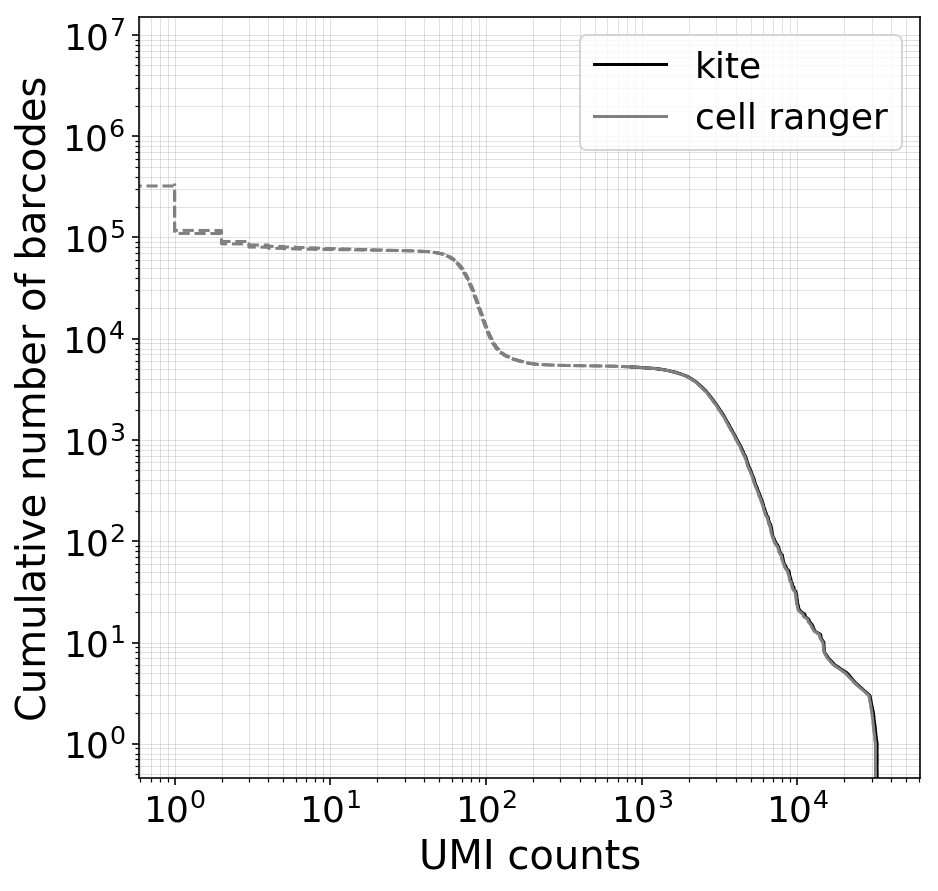

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

ax = knee_plot(raw.obs["counts"], ax, label="", color="grey", linestyle="dashed")
knee_plot_settings(raw.obs["counts"], ax)

ax = knee_plot(raw_cr.obs["counts"], ax, label="", color="grey", linestyle="dashed")
knee_plot_settings(kite.obs["counts"], ax)


ax = knee_plot(kite.obs["counts"], ax, label="kite", color="black")
knee_plot_settings(kite.obs["counts"], ax)

ax = knee_plot(cr.obs["counts"], ax, label="cell ranger", color="grey")
knee_plot_settings(cr.obs["counts"], ax)

plt.legend()

plt.show()

## PCA on normalized counts

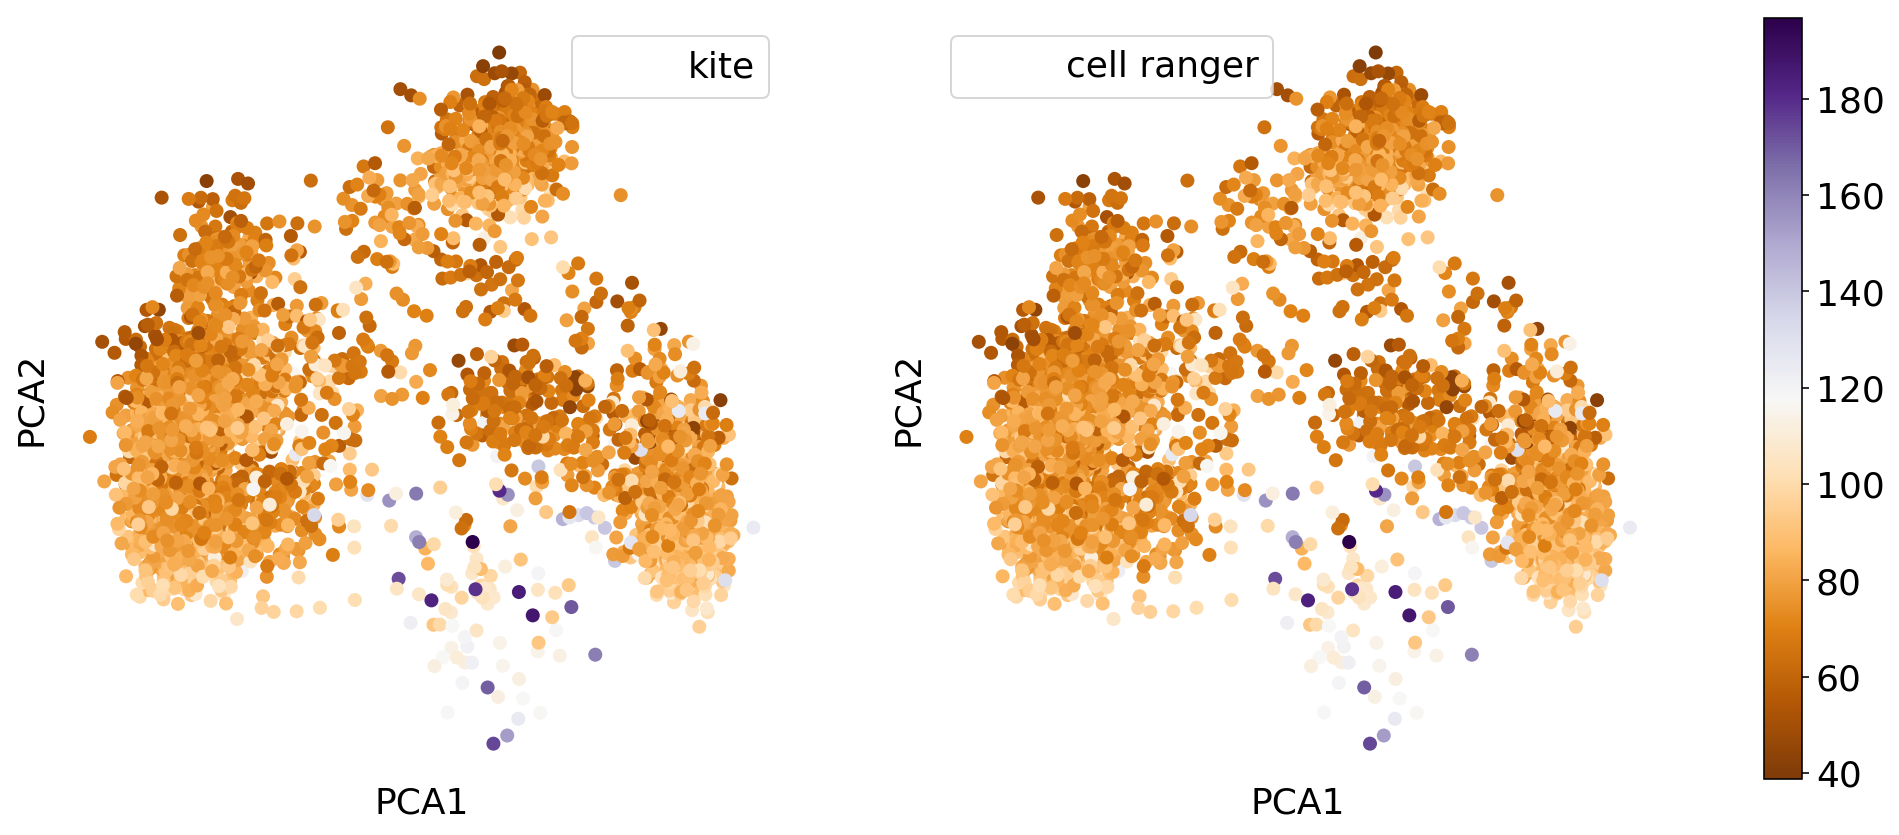

In [ ]:
fig, ax = plt.subplots(figsize=(9*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"PCA0":"PCA1"].values, labels=kite.obs.log1p_counts, ax=ax[0], ax_label="PCA", plot_label="kite")
im = plot_embedding(cr.obs.loc[:,"PCA0":"PCA1"].values, labels=cr.obs.log1p_counts, ax=ax[1], ax_label="PCA", plot_label="cell ranger")

fig.colorbar(im, ax=ax.ravel().tolist())

plt.show()

## UMAP on normalized counts

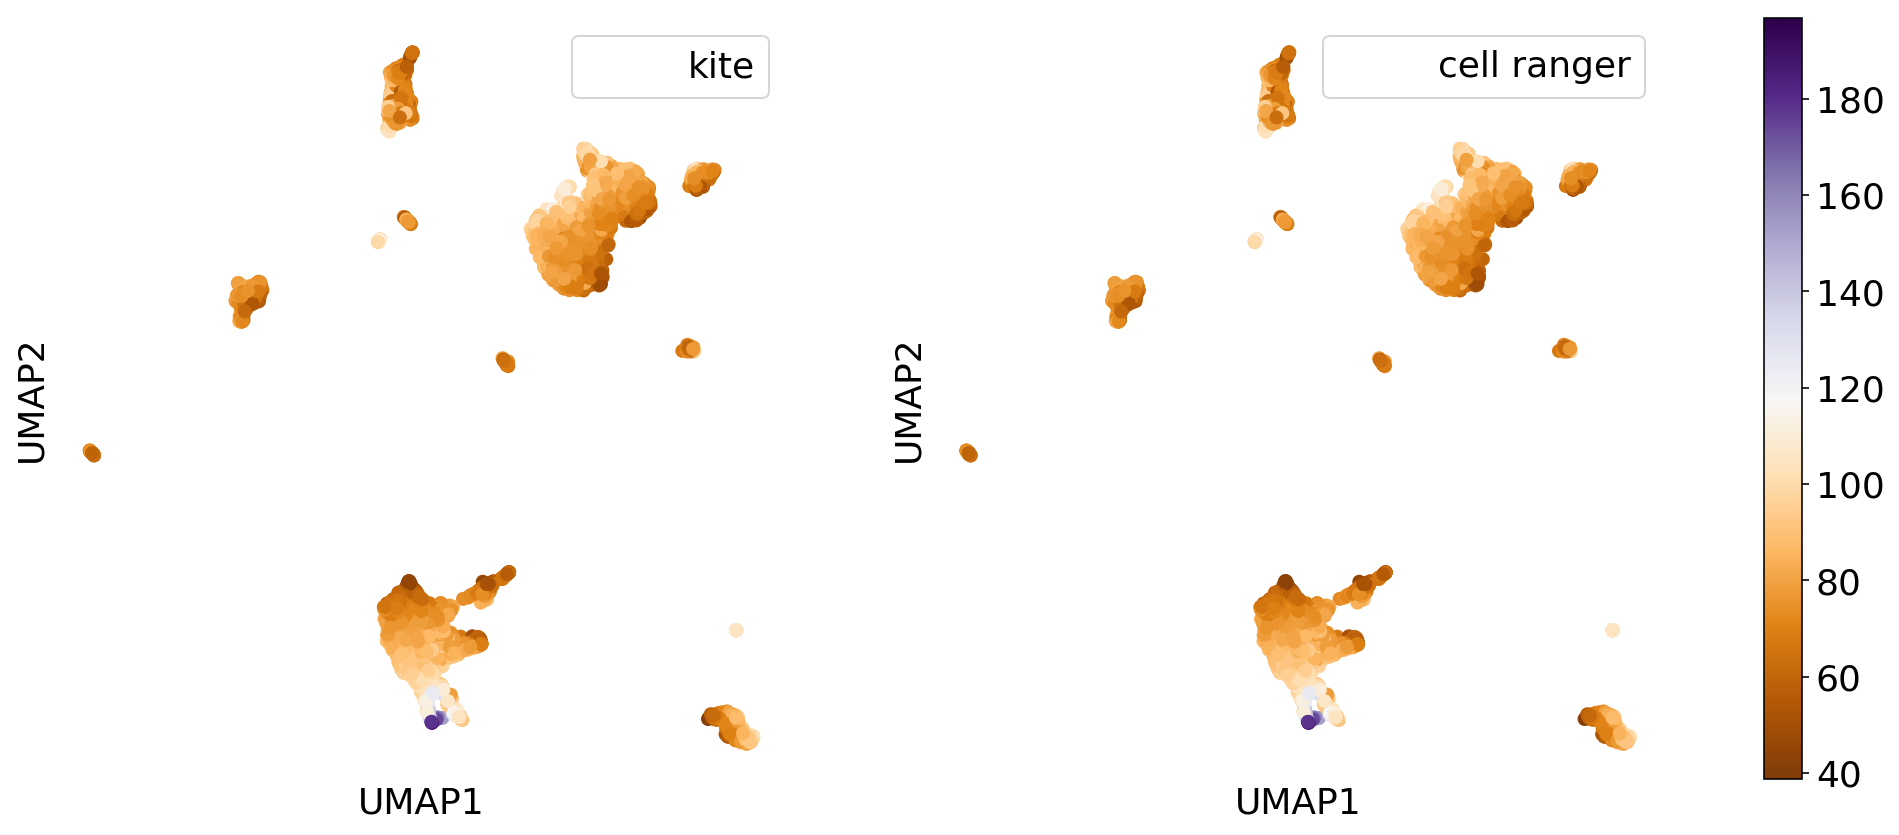

In [ ]:
fig, ax = plt.subplots(figsize=(9*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"UMAP0":"UMAP1"].values, labels=kite.obs.log1p_counts, ax=ax[0], ax_label="UMAP", plot_label="kite")
im = plot_embedding(cr.obs.loc[:,"UMAP0":"UMAP1"].values, labels=cr.obs.log1p_counts, ax=ax[1], ax_label="UMAP", plot_label="cell ranger")

fig.colorbar(im, ax=ax.ravel().tolist())

plt.show()

## tSNE on normalized counts

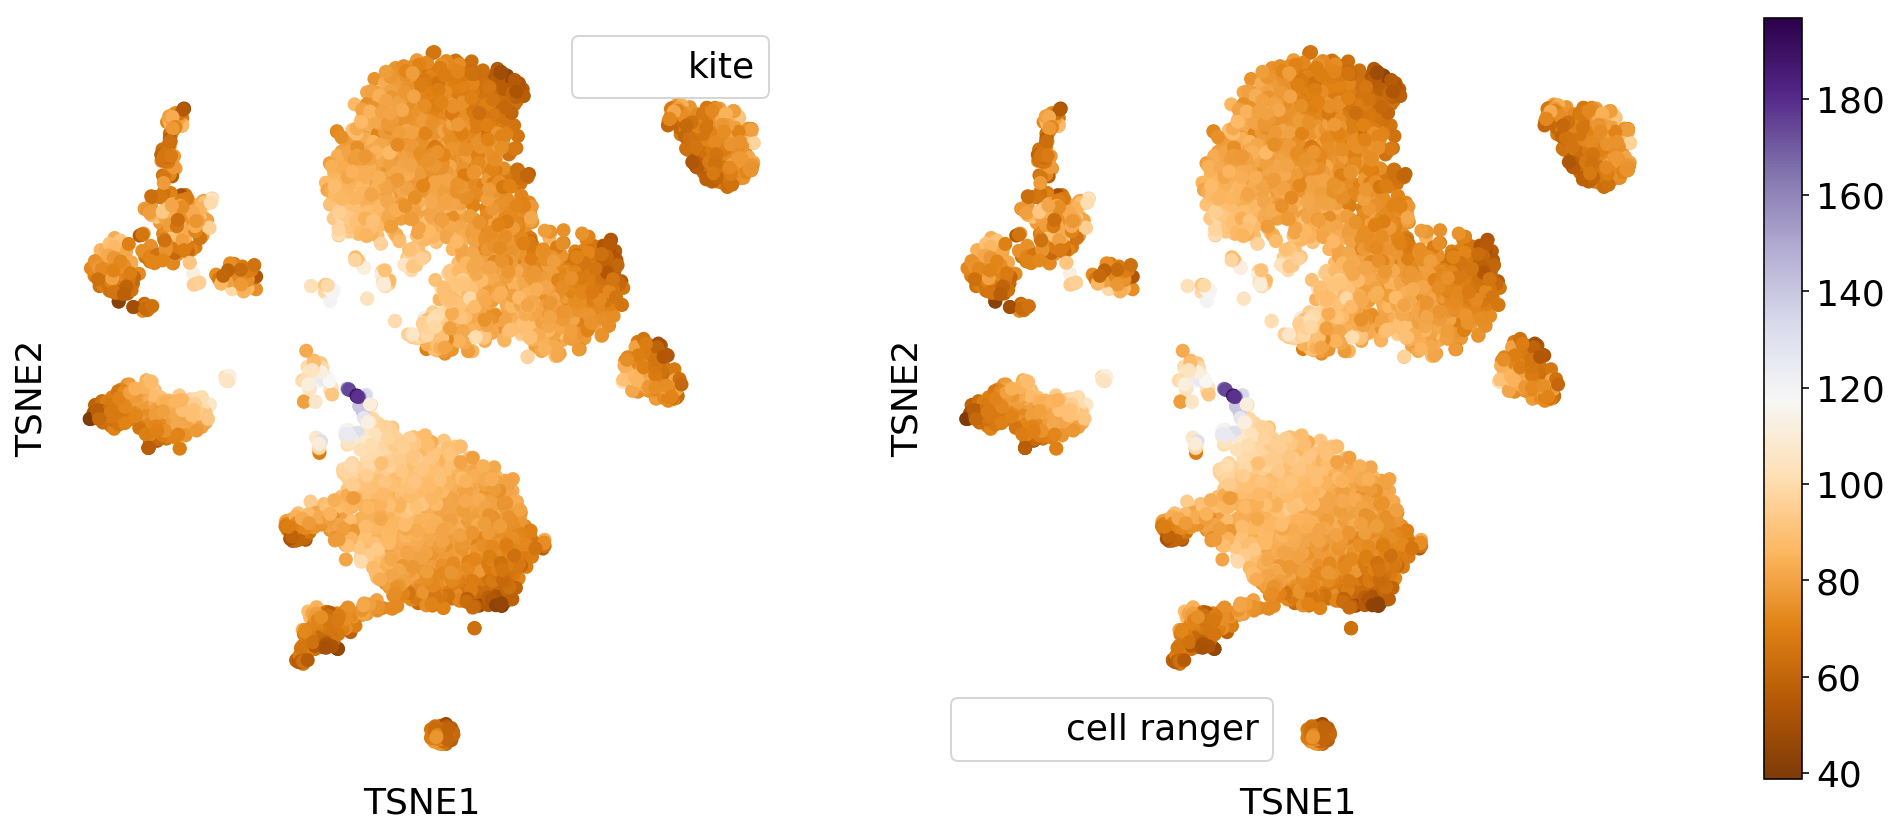

In [ ]:
fig, ax = plt.subplots(figsize=(9*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"TSNE0":"TSNE1"].values, labels=kite.obs.log1p_counts, ax=ax[0], ax_label="TSNE", plot_label="kite")
im = plot_embedding(cr.obs.loc[:,"TSNE0":"TSNE1"].values, labels=cr.obs.log1p_counts, ax=ax[1], ax_label="TSNE", plot_label="cell ranger")

fig.colorbar(im, ax=ax.ravel().tolist())

plt.show()

## Each dot is a cell, sum counts and compare

In [ ]:
kite_bulk = kite[kite.obs.index.isin(common_bcs)].obs.counts
cr_bulk = cr[cr.obs.index.isin(common_bcs)].obs.counts

raw_bulk = raw[raw.obs.index.isin(raw_bcs)].obs.counts
raw_cr_bulk = raw_cr[raw_cr.obs.index.isin(raw_bcs)].obs.counts

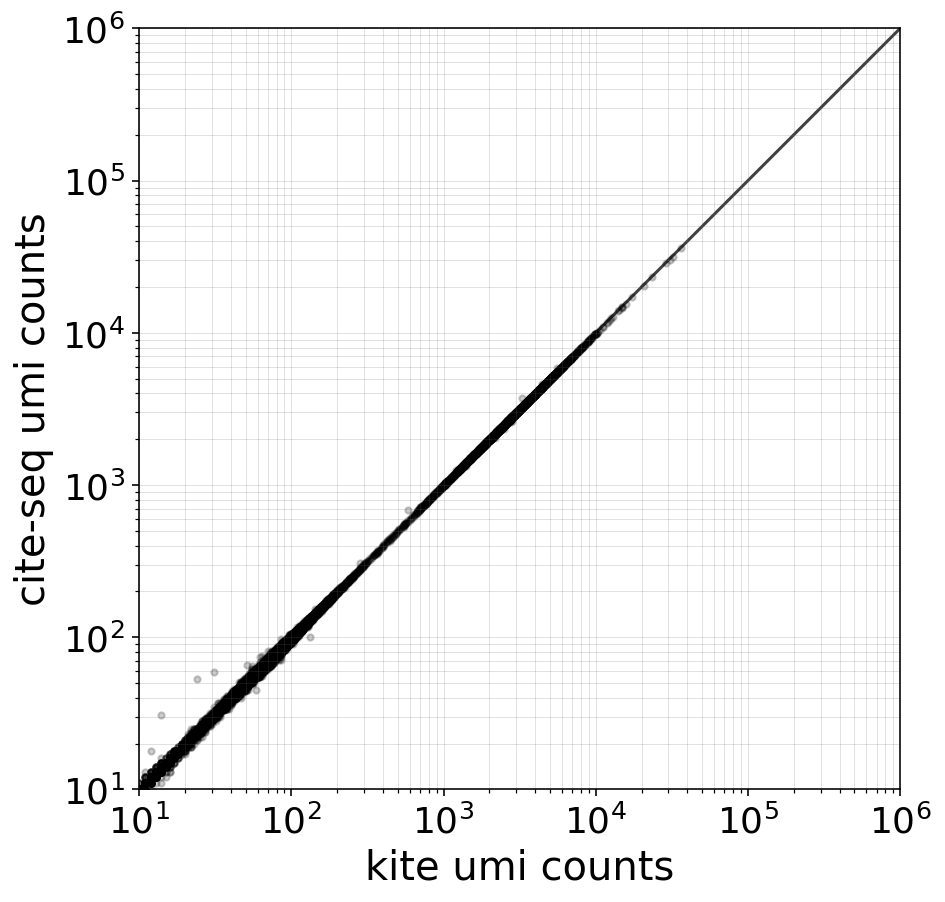

In [ ]:
fig, ax = plt.subplots(figsize=(7*1, 7), ncols=1)

plot_bulk(raw_bulk, raw_cr_bulk, xlabel="kite umi counts", ylabel="cite-seq umi counts", ax=ax, color="black")

plt.show()

In [ ]:
print("r-squared values\n--")
slope, intercept, r_value, p_value, std_err = stats.linregress(kite_bulk, cr_bulk)
print("kite & cite-seq:\t", r_value**2)

r-squared values
--
kite & cite-seq:	 0.9998831659380055


## Pearson correlation on barcodes

In [ ]:
corr_1 = sparse_M_corr(raw[raw_bcs].X.T, raw_cr[raw_bcs].X.T)

/home/sina/tools/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


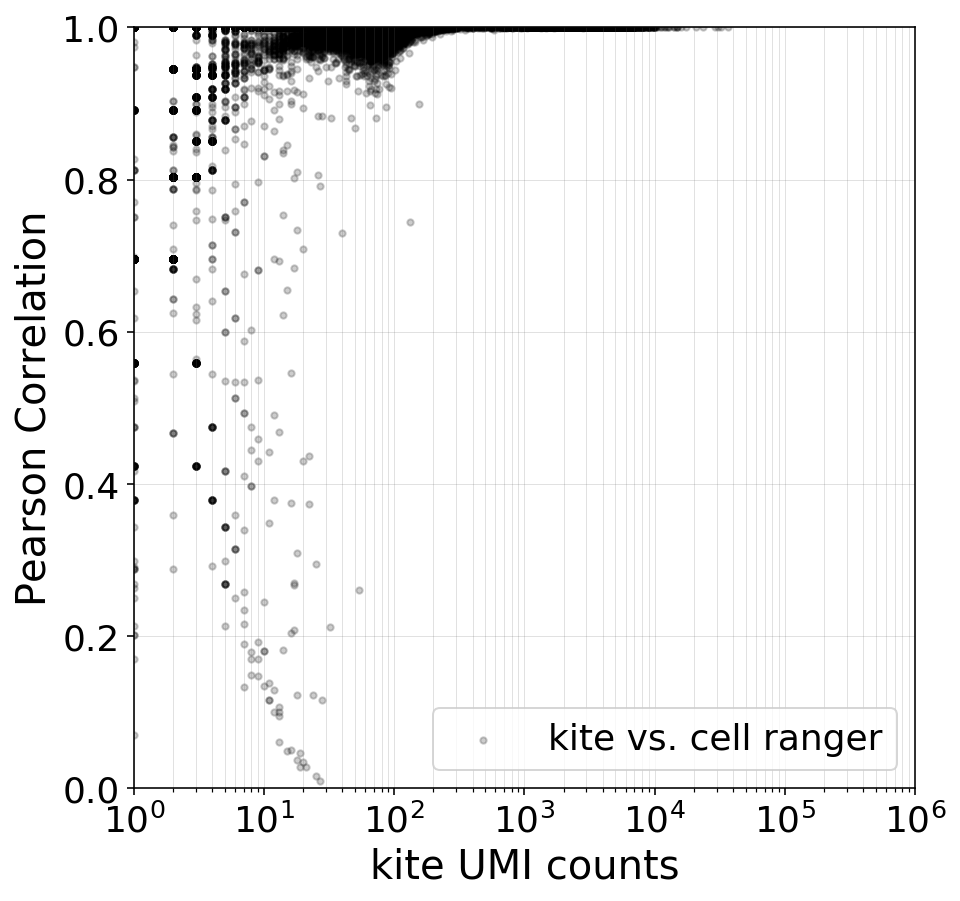

In [ ]:
fig, ax = plt.subplots(figsize=(7*1, 7), ncols=1)

corr_plot(raw[raw_bcs].obs["counts"].values, corr_1, ax=ax, xlabel="kite UMI counts", leg=["kite", "cell ranger"])

plt.legend(loc="lower right")
plt.show()

## Barcode distances

In [ ]:
from sklearn.metrics.pairwise import manhattan_distances
import datetime

In [ ]:
# taking manhattan distance between matrices
dnck = manhattan_distances(cr.layers['log1p'], kite.layers['log1p'])
dnkk = manhattan_distances(kite.layers['log1p'], kite.layers['log1p'])
print(datetime.datetime.now())

# nkc are the kallisto-cellranger distances 
nck = np.diagonal(dnck)

# ncc are the kallisto-kallisto distances
nkk = []
for row in dnkk:
    val = np.partition(row, 1)[1]
    nkk.append(val)
print('L1 distances done!')
print(datetime.datetime.now())

2020-01-08 13:55:39.382894
L1 distances done!
2020-01-08 13:55:39.493983


In [ ]:
from matplotlib.gridspec import GridSpec


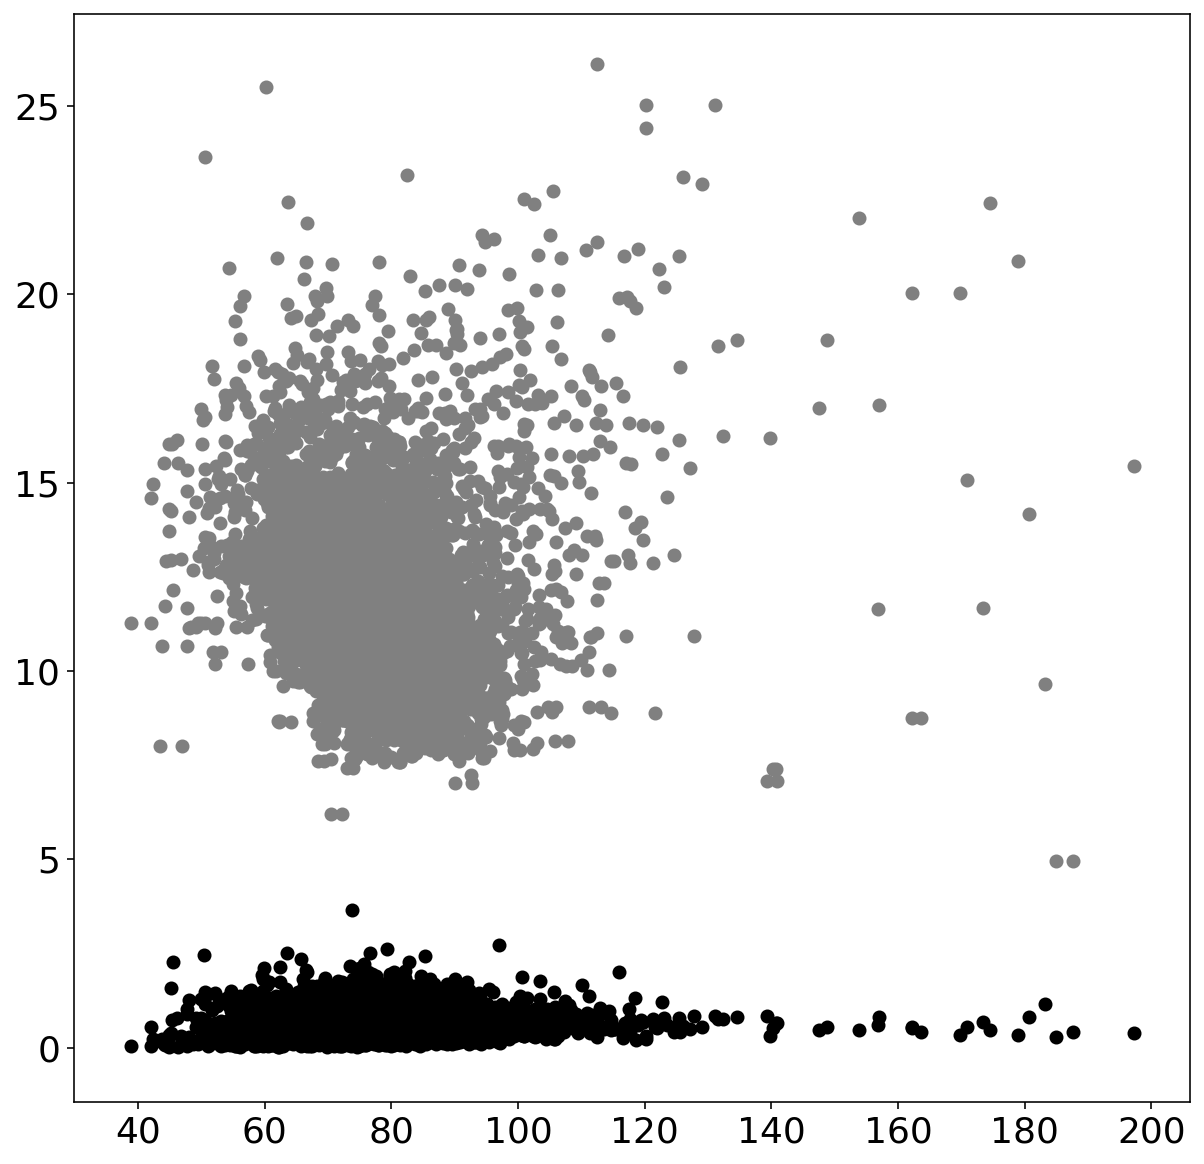

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

x = kite.obs.log1p_counts.values
ax.scatter(x, nkk, color="grey")
ax.scatter(x, nck, color="black")

plt.show()

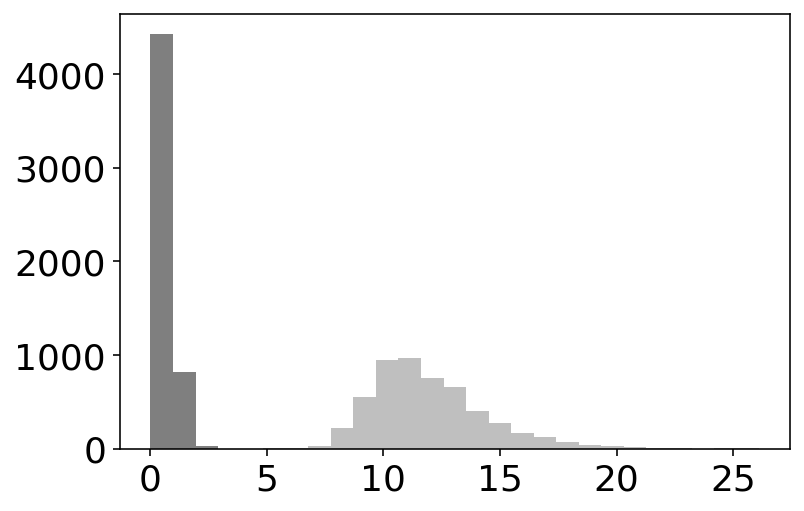

In [ ]:
fig, ax = plt.subplots()
hist, concat_bins = np.histogram(np.concatenate((nkk,nck)), bins='auto')
hist, ck_bins =  np.histogram(nck, bins='auto')
hist, cc_bins =  np.histogram(nkk, bins='auto')
best_bins = min([ck_bins,concat_bins,cc_bins], key=len)

ax.hist(x=nck, bins=best_bins, alpha=0.5, color = "black", label="Closest Cell Ranger barcode")
ax.hist(x=nkk, bins=best_bins, alpha=0.5, color = "grey", label="Closest kallisto barcode")

plt.show()

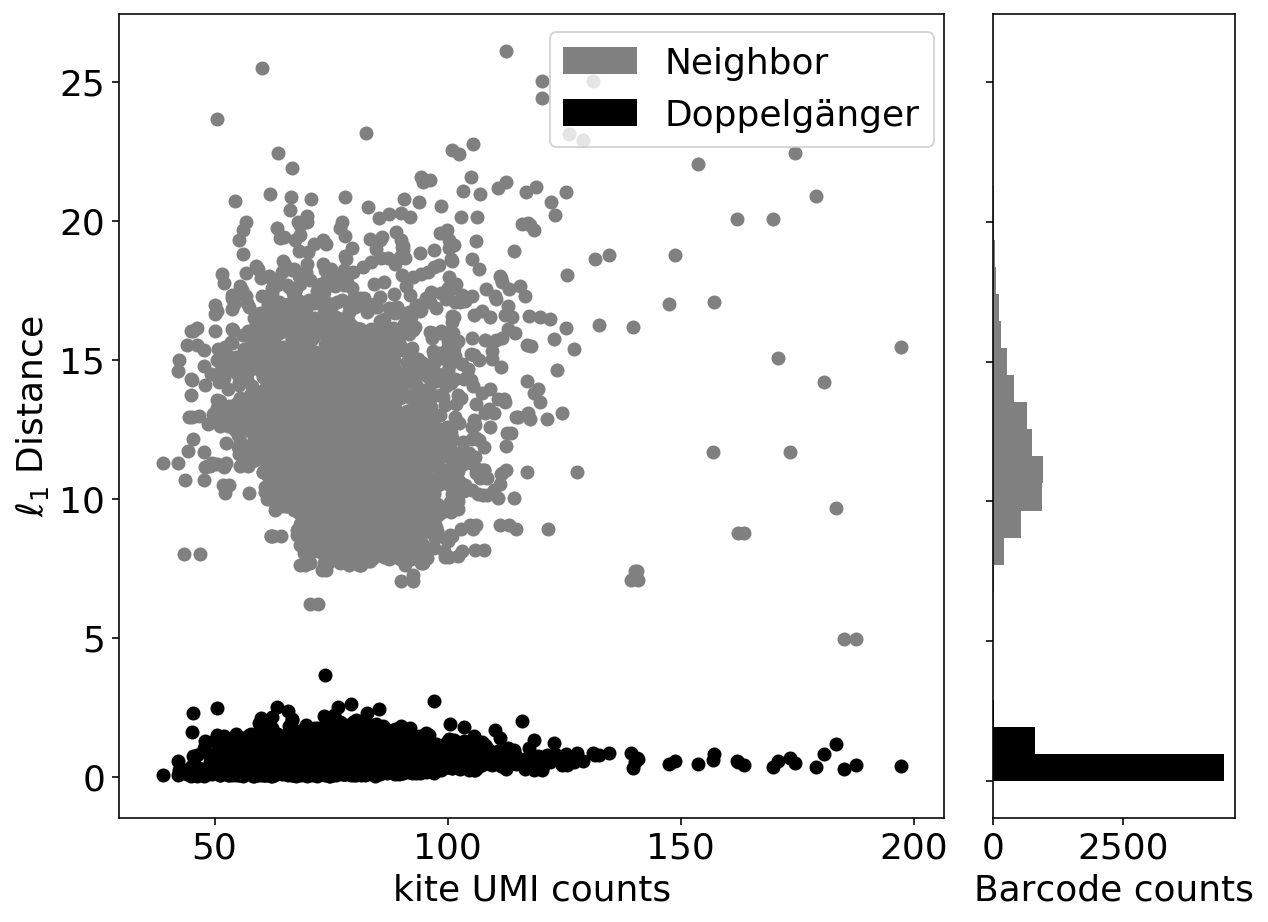

In [ ]:
x = np.random.rand(50)
y = np.random.rand(50)

fig = plt.figure(figsize=(10,10))

x = kite.obs.log1p_counts.values

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
#ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x, nkk, color="grey")
ax_joint.scatter(x, nck, color="black")


hist, concat_bins = np.histogram(np.concatenate((nkk,nck)), bins='auto')
hist, ck_bins =  np.histogram(nck, bins='auto')
hist, cc_bins =  np.histogram(nkk, bins='auto')
best_bins = min([ck_bins,concat_bins,cc_bins], key=len)

ax_marg_y.hist(x=nck, bins=best_bins, color = "black", label="Closest Cell Ranger barcode", orientation="horizontal")
ax_marg_y.hist(x=nkk, bins=best_bins, color = "grey", label="Closest kallisto barcode", orientation="horizontal")

# Turn off tick labels on marginals
#plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('kite UMI counts')
ax_joint.set_ylabel('$\ell_1$ Distance')

# Set labels on marginals
ax_marg_y.set_xlabel('Barcode counts')


grey_patch = mpatches.Patch(color='grey', label='Neighbor')
black_patch = mpatches.Patch(color='black', label='Doppelgänger')
plt.legend(handles=[grey_patch, black_patch], loc="upper left", bbox_to_anchor=(-1.9, 1))

plt.show()

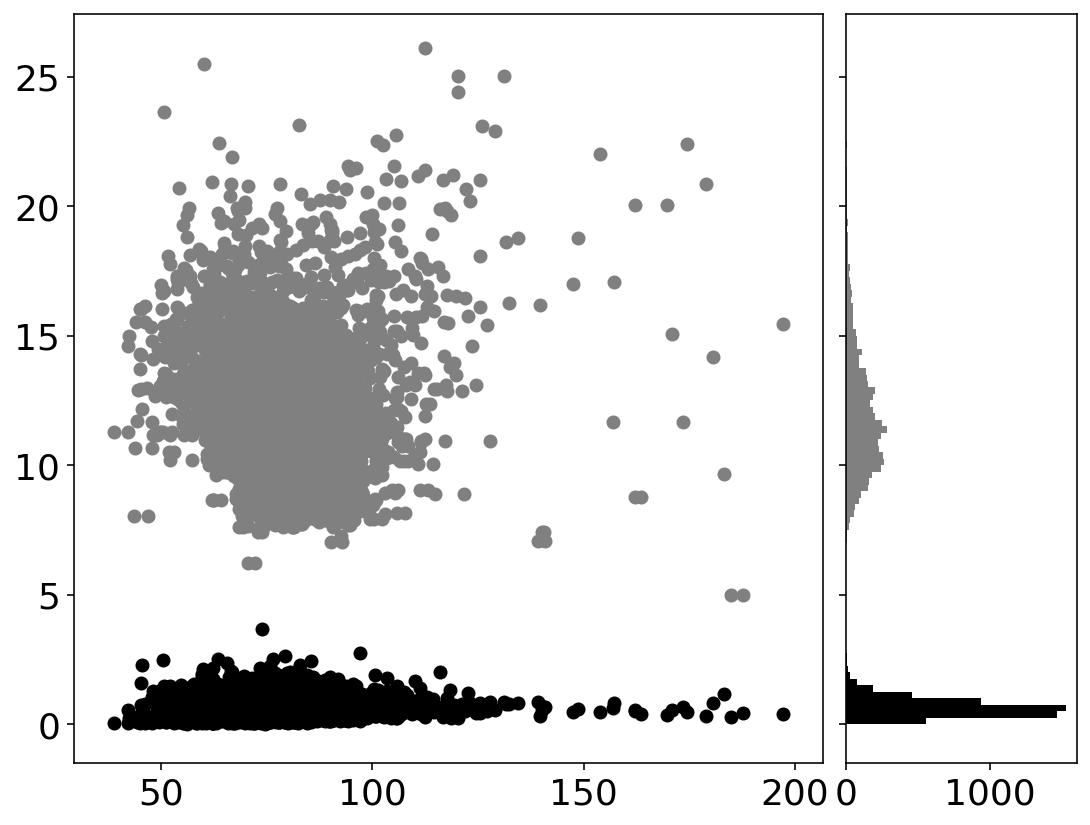

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter


# the random data
x = kite.obs.log1p_counts.values



nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHisty = plt.axes(rect_histy)

# no labels
#axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, nkk, color="grey")
axScatter.scatter(x, nck, color="black")

# now determine nice limits by hand:
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(nkk))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)

axHisty.hist(nkk, bins=bins, orientation='horizontal', color="grey")
axHisty.hist(nck, bins=bins, orientation='horizontal', color="black")

axHisty.set_ylim(axScatter.get_ylim())

plt.show()

In [ ]:
def mod_l1_plot(counts, nkk, nck, ax_left, ax_right):
    nullfmt = NullFormatter()
    ax_right.yaxis.set_major_formatter(nullfmt)
    ax_left.scatter(counts, nkk, color="grey")
    ax_left.scatter(counts, nck, color="black")
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(nkk))])
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)

    ax_right.hist(nkk, bins=bins, orientation='horizontal', color="grey", label="kallisto")
    ax_right.hist(nck, bins=bins, orientation='horizontal', color="black", label="Cell Ranger")
    ax_right.legend()

    ax_right.set_ylim(ax_left.get_ylim())
    ax_right.set_xlabel("Barcode counts")
    ax_left.set_xlabel("kallisto UMI counts")
    ax_left.set_ylabel("$\ell_1$ Distance")
    
    return ax

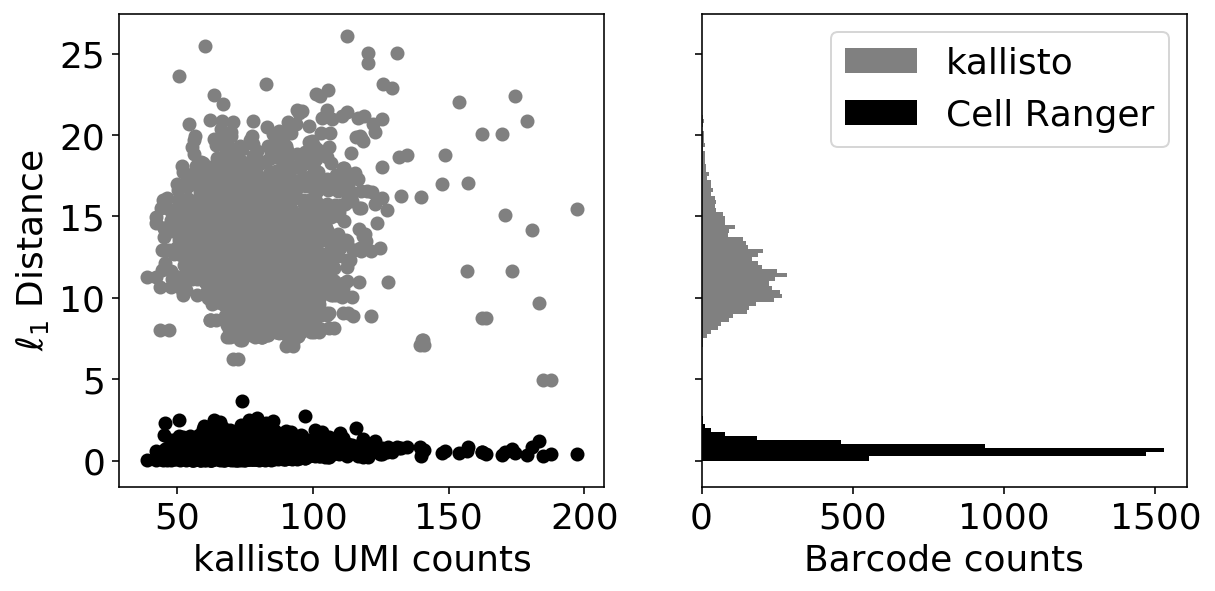

In [ ]:
x = kite.obs.log1p_counts.values

fig = plt.figure(figsize=(20, 20))


ax_left = plt.subplot2grid((4, 4), (1, 2), colspan=1)
ax_right = plt.subplot2grid((4, 4), (1, 3), colspan=1)

mod_l1_plot(x, nkk, nck, ax_left, ax_right)
plt.show()

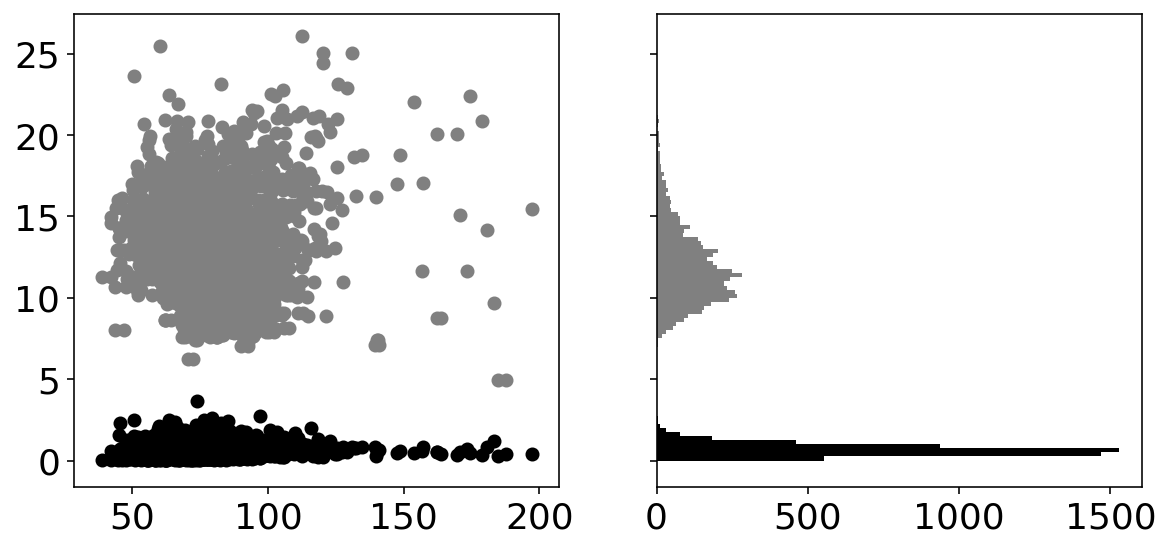

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from mpl_toolkits.axes_grid.inset_locator import inset_axes
#inset_axes = inset_axes(parent_axes,
#                    width="30%", # width = 30% of parent_bbox
#                    height=1., # height : 1 inch
#                    loc=3)
# the random data
x = kite.obs.log1p_counts.values

fig = plt.figure(figsize=(20, 20))


ax_left = plt.subplot2grid((4, 4), (1, 2), colspan=1)
ax_right = plt.subplot2grid((4, 4), (1, 3), colspan=1)

nullfmt = NullFormatter()         # no labels



# no labels
#axHistx.xaxis.set_major_formatter(nullfmt)
ax_right.yaxis.set_major_formatter(nullfmt)

# the scatter plot:


# now determine nice limits by hand:


plt.show()

# Leiden clustering

In [ ]:
import scanpy as sc

In [ ]:
norm = kite.layers["norm"]
X = kite.X

kite.layers["raw"] = X
kite.X = norm

In [ ]:
sc.pp.neighbors(kite)

sc.tl.leiden(kite, resolution=0.05)

In [ ]:
kite

AnnData object with n_obs × n_vars = 5265 × 32 
    obs: 'counts', 'num_nonzero', 'log1p_counts', 'PCA0', 'PCA1', 'TSNE0', 'TSNE1', 'UMAP0', 'UMAP1', 'leiden'
    uns: 'neighbors', 'leiden'
    layers: 'norm', 'log1p', 'raw'

In [ ]:
kite.obs.leiden.value_counts()

0    2371
1    1594
2     583
3     334
4     319
5      64
Name: leiden, dtype: int64

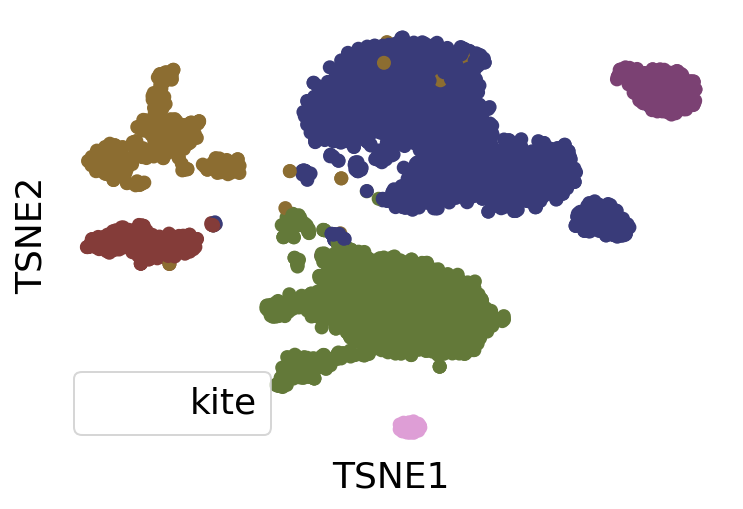

In [ ]:
fig, ax = plt.subplots()

plot_discrete_embedding(kite.obs.loc[:,"TSNE0":"TSNE1"].values, labels=kite.obs.leiden.astype(int), ax=ax, ax_label="TSNE", plot_label="kite")
plt.show()

In [ ]:
kite

AnnData object with n_obs × n_vars = 5265 × 32 
    obs: 'counts', 'num_nonzero', 'log1p_counts', 'PCA0', 'PCA1', 'TSNE0', 'TSNE1', 'UMAP0', 'UMAP1', 'leiden'
    uns: 'neighbors', 'leiden', 'leiden_DE'
    layers: 'norm', 'log1p', 'raw'

In [ ]:
blah =sc.tl.rank_genes_groups(kite, groupby='cell_ontology_class', use_raw=True, method='t-test_overestim_var', n_genes=10) # compute differential expression ngenes=kite.shape[1], copy=True)

KeyError: 'cell_ontology_class'

In [ ]:
blah.uns["leiden_DE"]

{'params': {'groupby': 'leiden',
  'reference': 'rest',
  'method': 't-test_overestim_var',
  'use_raw': True,
  'corr_method': 'benjamini-hochberg'},
 'scores': rec.array([(180.18158   ,  83.859375 ,  33.463055  ,  50.57526   ,  47.540874  , 43.881924 ),
            ( 56.20383   ,  78.9826   ,  26.384832  ,  43.49803   ,  25.613321  ,  7.981647 ),
            ( 47.841965  ,  76.84521  ,  15.126025  ,  21.285538  ,  21.503664  ,  7.658672 ),
            ( 46.32887   ,  32.703316 ,  11.0139    ,  14.365167  ,  12.929389  ,  5.5080476),
            ( 33.705097  ,   0.7428744,   9.860905  ,  10.409797  ,  11.975611  ,  3.2822344),
            ( 32.106766  ,  -1.8306545,   9.1515465 ,   3.0247881 ,   9.57432   ,  2.968631 ),
            ( 13.5671215 ,  -2.0349429,   8.490167  ,   2.646079  ,   5.225582  ,  2.9290576),
            ( 11.62497   ,  -2.3420277,   8.264687  ,  -0.34345925,   2.641607  ,  2.6623929),
            (  7.5547166 ,  -2.4157693,   7.326585  ,  -0.91513836,   2.082876 

# All together!

In [ ]:
# fig, ax = plt.subplots(figsize=(7*2, 7*3), nrows = 3, ncols=2)
# xlim = (0, 10**5)
# 
# ################ Knee Plot
# loc = ax[0, 0]
# 
# knee_plot(raw.obs["counts"], loc, label="", color="grey", linestyle="dashed")
# knee_plot_settings(raw.obs["counts"], loc)
# 
# knee_plot(raw_cr.obs["counts"], loc, label="", color="grey", linestyle="dashed")
# knee_plot_settings(kite.obs["counts"], loc)
# 
# knee_plot(kite.obs["counts"], loc, label="kite", color="black")
# knee_plot_settings(kite.obs["counts"], loc)
# 
# knee_plot(cr.obs["counts"], loc, label="cell ranger", color="grey")
# knee_plot_settings(cr.obs["counts"], loc)
# 
# loc.set_xlim(xlim)
# 
# ################## Bulk Correlation
# loc = ax[1, 0]
# plot_bulk(raw_bulk, raw_cr_bulk, xlabel="kite umi counts", ylabel="cell ranger umi counts", ax=loc, color="black")
# loc.set_xlim(xlim)
# 
# ################## Single Cell Correlation
# loc = ax[2, 0]
# corr_plot(raw[raw_bcs].obs["counts"].values, corr_1, ax=loc, xlabel="kite UMI counts", leg=["kite", "cell ranger"])
# loc.set_xlim(xlim)
# 
# plt.legend()
# fig.tight_layout()
# plt.show()